In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
import xgboost
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder,StandardScaler
import warnings
warnings.filterwarnings("ignore")
from sklearn.decomposition import PCA
from scipy.stats import boxcox

In [2]:
df1 = pd.read_excel('Medibuddy insurance data personal details copy.xlsx')

In [3]:
df2 = pd.read_excel('Medibuddy Insurance Data Price (1) (1).csv.xlsx')

In [4]:
df = df1.merge(df2,on=['Policy no.'])

In [5]:
df_copy = df

In [6]:
df.drop('Policy no.',axis=1,inplace=True)

In [7]:
df.isnull().sum()

children          0
smoker            0
region            0
age               0
sex               0
bmi               0
charges in INR    0
dtype: int64

In [8]:
df_num = df[['age','bmi','children','charges in INR']]

# Descriptive statistics

In [9]:
def custom_summary(df):
    result = []
    for col in df.columns:
        if df[col].dtype !='object':
            stats = OrderedDict({
                'column_Name':col,
                'Count':df[col].count(),
                'Minimum':df[col].min(),
                'Quartile_1':df[col].quantile(0.25),
                'mean':df[col].mean(),
                'median':df[col].median(),
                'Quartile_3':df[col].quantile(0.75),
                'maximum':df[col].max(),
                'Variance':round(df[col].var(),2),
                'Standard_devaition':round(df[col].std(),2),
                'skewness':round(df[col].skew(),2),
                'kurtosis':round(df[col].kurt(),2),
                'IQR':df[col].quantile(0.75)-df[col].quantile(0.25)})
            result.append(stats)
            
            if df[col].skew()<-1:
                sk_label = 'Highly Negatively Skewed'
            elif -1 < df[col].skew() < -0.5:
                sk_label = 'Moderatly Negatively Skewed'
            elif -0.5 < df[col].skew() <0:
                sk_label = 'Fairly Negatively Skewed'
            elif 0 < df[col].skew() < 0.5:
                sk_label = 'Fairly Postively Skewed'
            elif 0.5 < df[col].skew() <1:
                sk_label = 'Moderately Postively Skewed'
            elif df[col].skew() > 1:
                sk_label = 'Higly Positively Skewed'
                
            stats['Skewness_Comment'] = sk_label
            
            if df[col].kurt() < -1:
                kurt_label = 'Highly platykurtic'
            elif -1< df[col].kurt() < -0.5:
                kurt_label = 'Moderately Platykurtic'
            elif -0.5< df[col].kurt() < 0.5 :
                kurt_label = 'Mesokurtic'
            elif 0.5 < df[col].kurt() < 1:
                kurt_label ='Moderately Leptokurtic'
            elif df[col].kurt() > 1:
                kurt_label = 'Higly Leptokurtic'
                
            stats['Kurtosis_comment'] = kurt_label
            
                
    result_df = pd.DataFrame(result)
                
    return result_df

In [10]:
custom_summary(df_num)

,column_Name,Count,Minimum,Quartile_1,mean,median,Quartile_3,maximum,Variance,Standard_devaition,skewness,kurtosis,IQR,Skewness_Comment,Kurtosis_comment
0,age,1338,18.0000,27.00000,39.207025,39.000,51.000000,64.00000,1.974000e+02,14.05,0.06,-1.25,24.000000,Fairly Postively Skewed,Highly platykurtic
1,bmi,1338,15.9600,26.29625,30.663397,30.400,34.693750,53.13000,3.719000e+01,6.10,0.28,-0.05,8.397500,Fairly Postively Skewed,Mesokurtic
2,children,1338,0.0000,0.00000,1.094918,1.000,2.000000,5.00000,1.450000e+00,1.21,0.94,0.20,2.000000,Moderately Postively Skewed,Mesokurtic
3,charges in INR,1338,1121.8739,4740.28715,13270.422265,9382.033,16639.912515,63770.42801,1.466524e+08,12110.01,1.52,1.61,11899.625365,Higly Positively Skewed,Higly Leptokurtic


In [11]:
#  As the charges in INR is highly positive skewed , so we can expect there are outliers in the data.
# the mean and median for children is 1.
# average person who claims 

# Outlier replace treatment

In [12]:

def remove_outliers(df, col):
    col_data = df[col]
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    low_limit = q1 - 1.5 * iqr
    up_limit = q3 + 1.5 * iqr
    df.loc[(col_data <= low_limit)] = low_limit
    df.loc[(col_data >= up_limit)] = up_limit
    
    return df

In [13]:
def odt_plot(df,col):
    f,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,6))
    
    # boxplot
    sns.boxplot(df[col],ax = ax1)
    ax1.set_title(f'boxplot of {col}')
    ax1.set_xlabel('boxplot')
    ax1.set_ylabel('values')
    
    # Histogram with outliers
    sns.distplot(df[col],ax=ax2)
    ax2.set_title(f'histogram of {col} with outliers')
    ax2.set_xlabel('density')
    ax2.set_ylabel('values')
    
    # Histogram without outliers
    y = remove_outliers(df_num,col)
    sns.distplot(y[col],ax=ax3)
    ax3.set_title(f'histogram of {col} without outliers')
    ax3.set_xlabel('density')
    ax3.set_ylabel('values')   
    

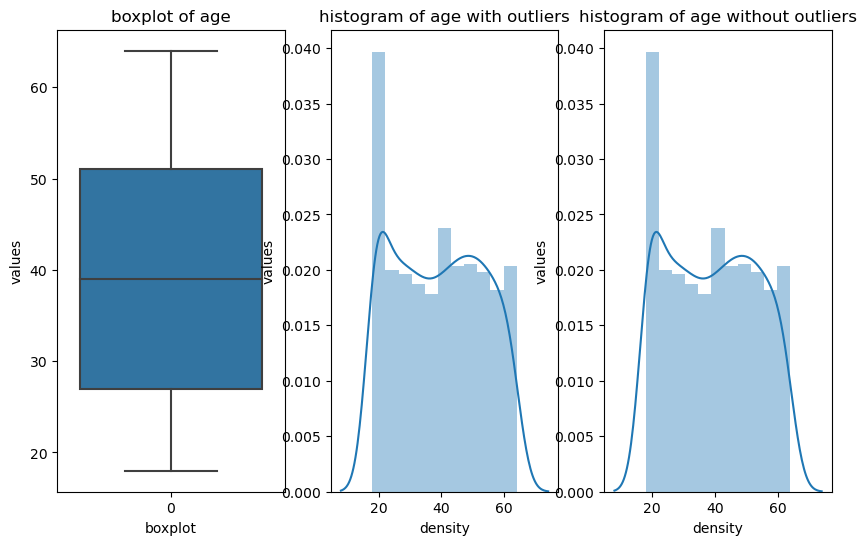

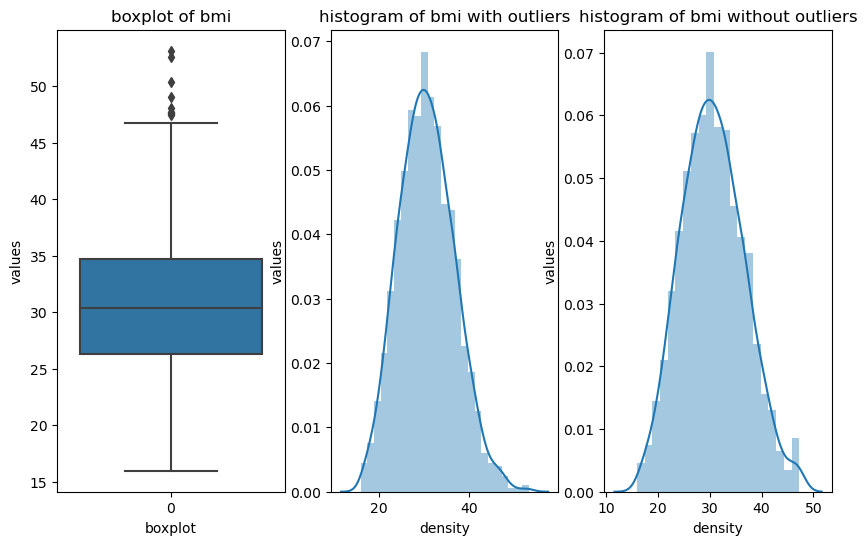

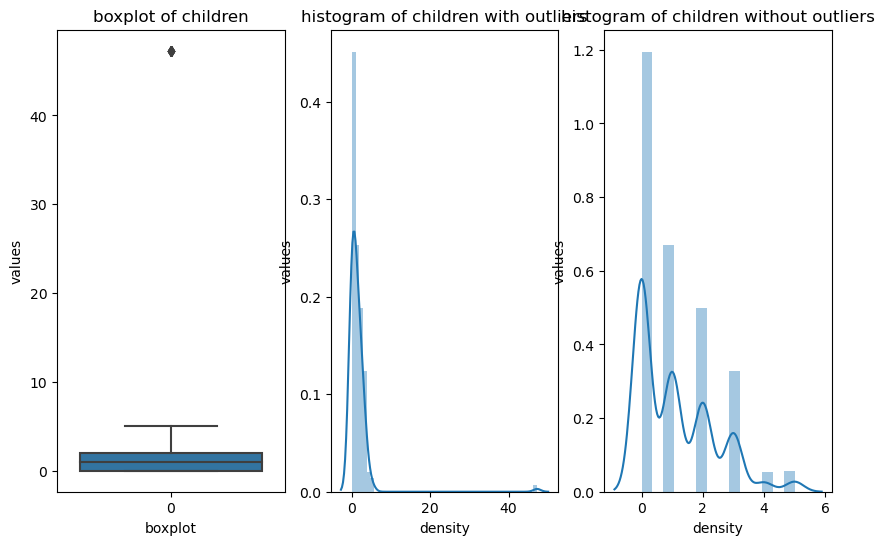

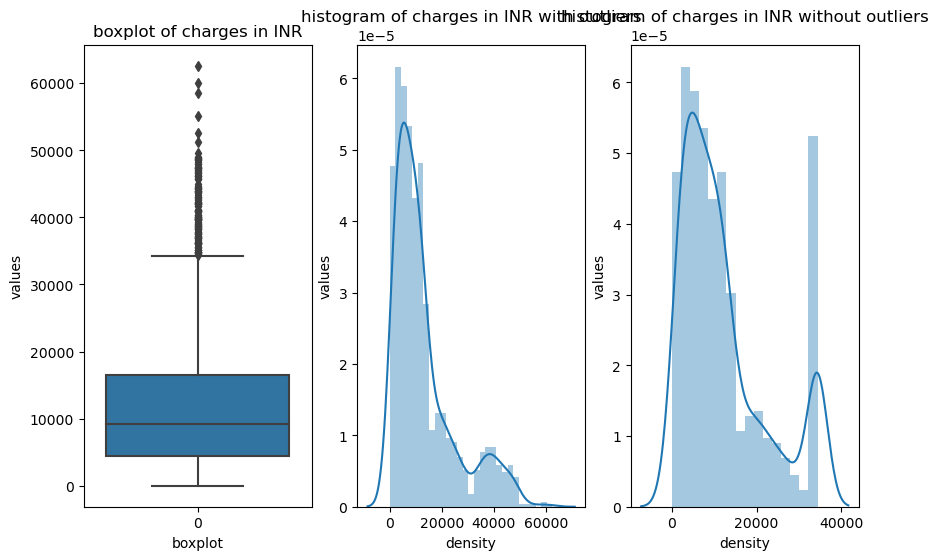

In [14]:
for col in df_num.columns:
    odt_plot(df_num,col)

In [15]:
#df['age']=df_num['age']
df['charges in INR']=df_num['charges in INR']
#df['children']=df_num['children']
#df['bmi']=df_num['bmi']


In [16]:
custom_summary(df)

,column_Name,Count,Minimum,Quartile_1,mean,median,Quartile_3,maximum,Variance,Standard_devaition,skewness,kurtosis,IQR,Skewness_Comment,Kurtosis_comment
0,children,1338,0.00,0.000000,1.094918,1.00000,2.000000,5.000000,1.450000e+00,1.21,0.94,0.20,2.000000,Moderately Postively Skewed,Mesokurtic
1,age,1338,18.00,27.000000,39.207025,39.00000,51.000000,64.000000,1.974000e+02,14.05,0.06,-1.25,24.000000,Fairly Postively Skewed,Highly platykurtic
2,bmi,1338,15.96,26.296250,30.663397,30.40000,34.693750,53.130000,3.719000e+01,6.10,0.28,-0.05,8.397500,Fairly Postively Skewed,Mesokurtic
3,charges in INR,1338,5.00,4462.842625,12244.640982,9188.00425,16443.294663,34413.972719,1.042796e+08,10211.74,1.07,0.01,11980.452037,Higly Positively Skewed,Mesokurtic


<Axes: xlabel='charges in INR', ylabel='Density'>

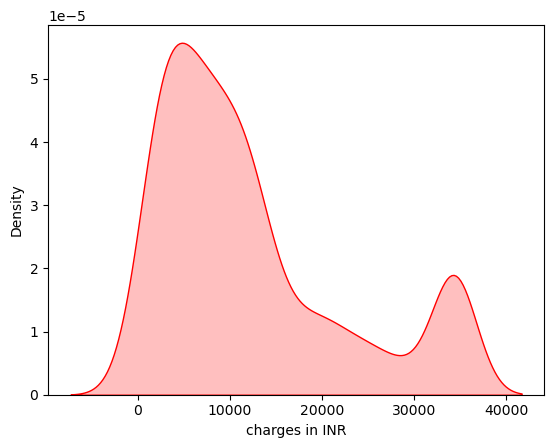

In [17]:
sns.kdeplot(df['charges in INR'], color='red', shade=True)

In [18]:
df['charges in INR'] = np.log1p(df['charges in INR'])

<Axes: xlabel='charges in INR', ylabel='Density'>

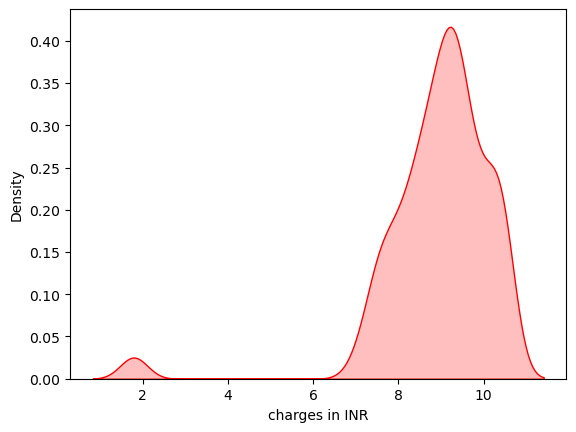

In [19]:
sns.kdeplot(df['charges in INR'], color='red', shade=True)

# Multivariate Analysis

In [20]:
le = LabelEncoder()

In [21]:
df['smoker']=le.fit_transform(df['smoker'])
df['region']=le.fit_transform(df['region'])
df['sex']=le.fit_transform(df['sex'])

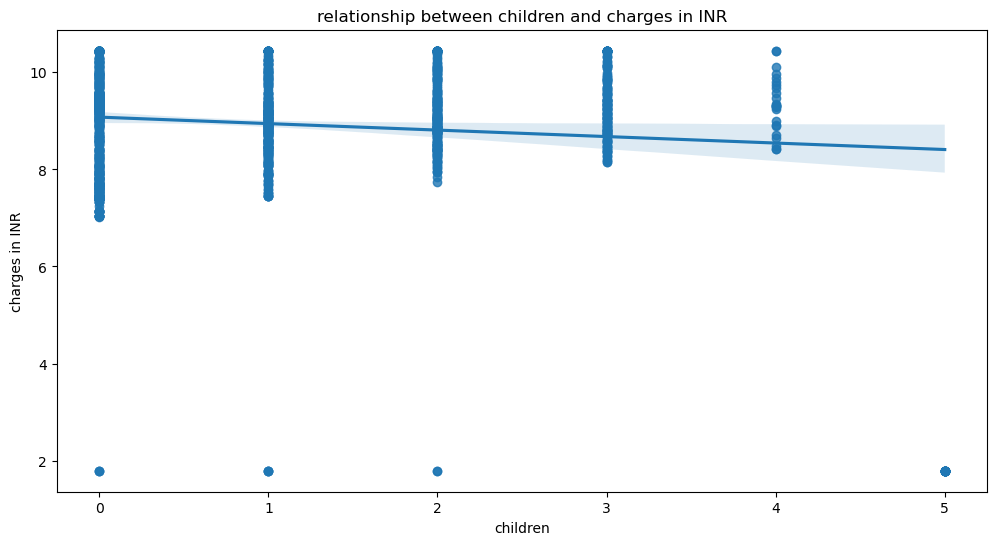

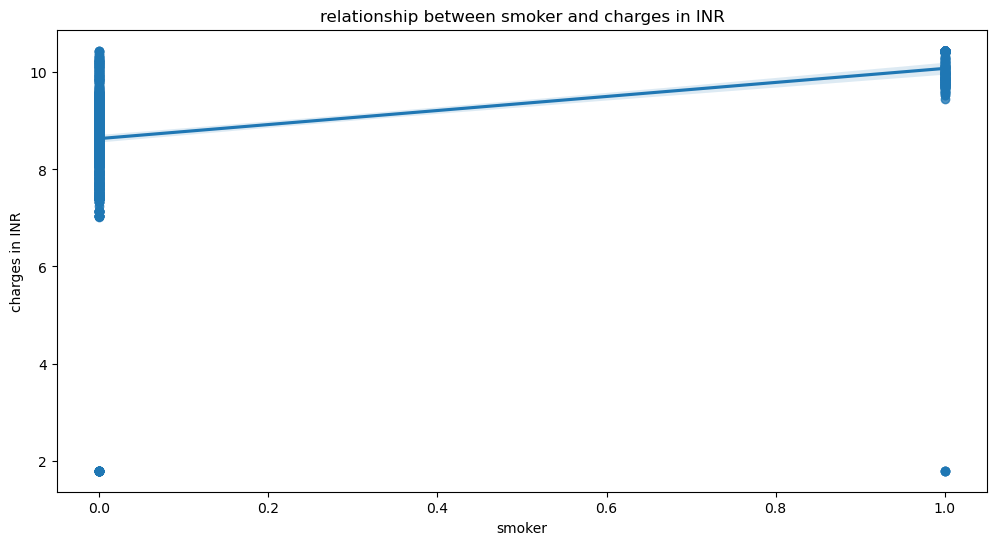

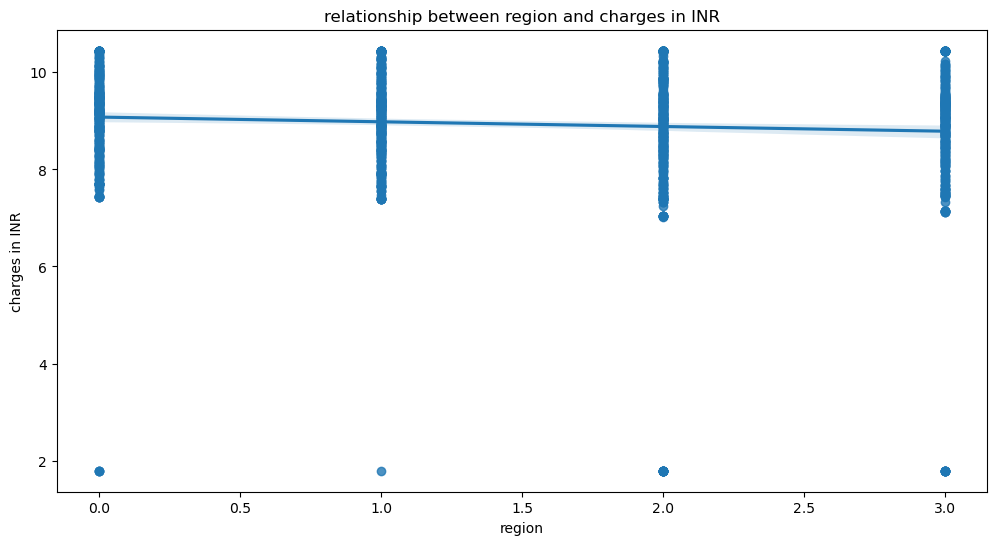

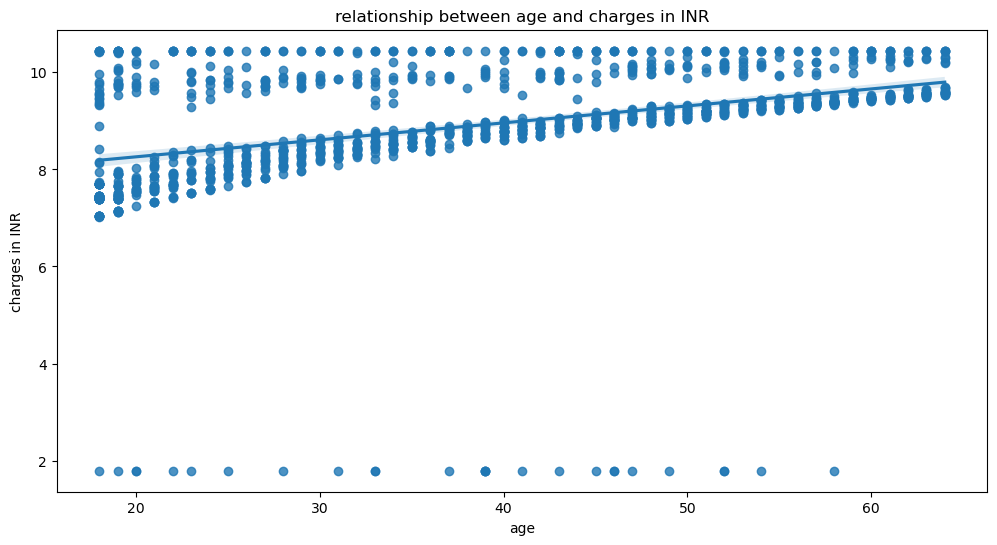

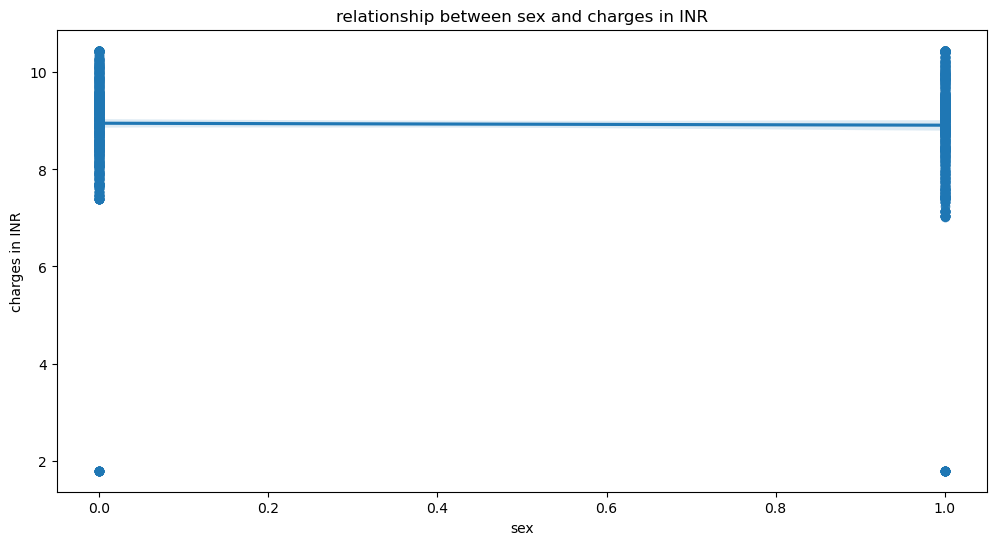

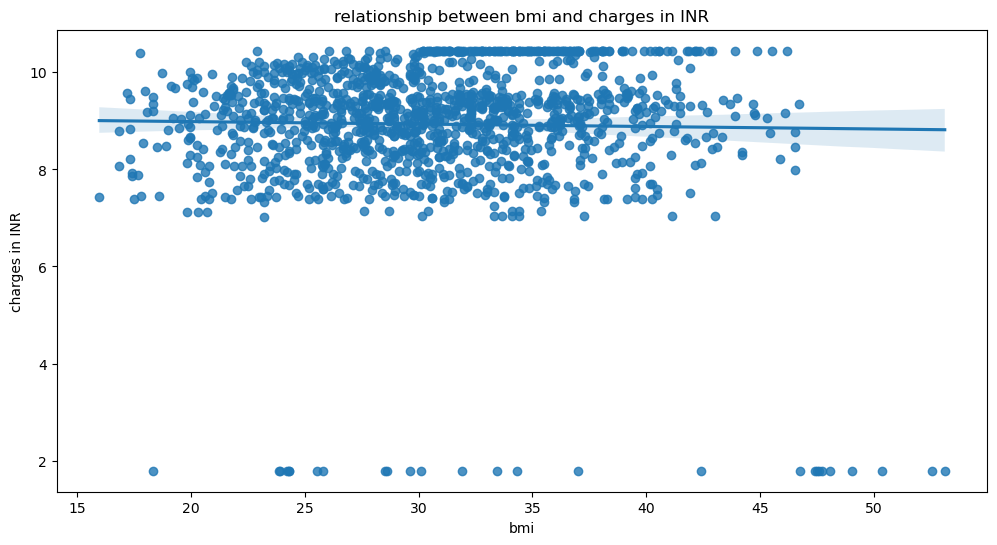

In [22]:
for col in df.columns:
        if col != 'charges in INR':
            f,ax1 = plt.subplots(figsize=(12,6))
            sns.regplot(x=df[col], y =df['charges in INR'], ax=ax1).set_title(f'relationship between {col} and charges in INR')

In [23]:
def correlation_target(df,target):
    ind_var = df.drop(target,axis=1).columns 
    corr_result = []
    for col in ind_var:
        corr_result.append(df[target].corr(df[col]))
        
    result_df = pd.DataFrame([ind_var,corr_result],index=["variable","correaltion"]).T
    return result_df.sort_values("correaltion",ascending=False)


In [24]:
correlation_target(df,'charges in INR')

,variable,correaltion
1,smoker,0.432309
3,age,0.363733
4,sex,-0.014923
5,bmi,-0.022813
2,region,-0.079302
0,children,-0.119191


<Axes: >

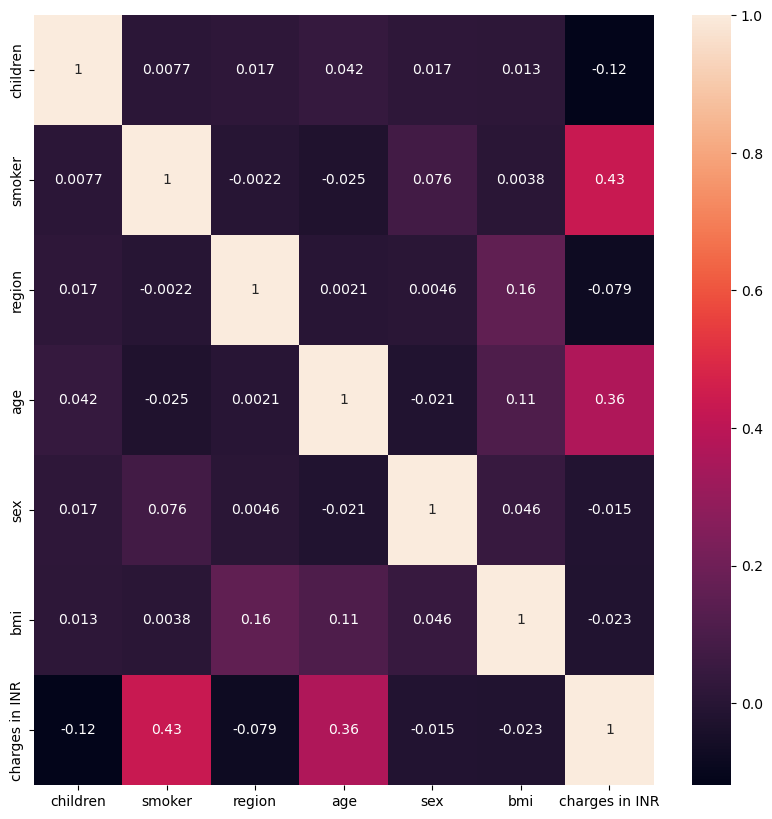

In [25]:
cor = df.corr()
f,ax = plt.subplots(figsize=(10,10))
sns.heatmap(cor,annot=True)

In [26]:
def vif_factor(df,target):
    ind_df = df.drop(target,axis=1)
    result_df = pd.DataFrame()
    result_df['variables'] = ind_df.columns
    result_df['vif_value'] = [variance_inflation_factor(ind_df.values,i)for i in range (ind_df.shape[1])]
    return  result_df

In [27]:
vif_factor(df,'charges in INR')

,variables,vif_value
0,children,1.801245
1,smoker,1.256837
2,region,2.924528
3,age,7.551348
4,sex,2.001061
5,bmi,10.371829


In [28]:
corr = df['bmi'].corr(df['age'])

In [29]:
corr

0.10927188154853516

# Applying PCA

In [30]:
def apply_pca(x):
    n_com = len(x.columns)
    sc = StandardScaler()
    x = sc.fit_transform(x)
    n_components = None
    for i in range(1, n_com):
        pca = PCA(n_components=i)
        p_components = pca.fit_transform(x)
        evr = np.cumsum(pca.explained_variance_ratio_)
        if evr[i-1] > 0.8:
            n_components = i
            break
    
   
        
    print('The total information captured is ', evr)
    col = ['pc_' + str(i) for i in range(1, n_components + 1)]
    
    result_df = pd.DataFrame(data=p_components[:, :n_components], columns=col)
    return result_df


In [31]:
x = df.drop('charges in INR',axis=1)

In [32]:
pca_df = apply_pca(x)

The total information captured is  [0.20060309 0.38196949 0.55189263 0.71276965 0.8667639 ]


In [33]:
pca_df.head()

,pc_1,pc_2,pc_3,pc_4,pc_5
0,-0.685217,0.693152,-1.849985,0.452551,-0.991684
1,0.383090,0.812865,-1.164123,1.402335,-0.956857
2,-2.283522,-0.085284,-0.845769,-1.017192,-0.801877
3,-0.503798,-0.773985,-1.180301,1.081068,0.427198
4,-0.377094,-0.411949,0.925302,3.797430,0.389267


In [34]:
pca_df = pca_df.join(df[['charges in INR']],how='left')

In [35]:
vif_factor(pca_df,'charges in INR')

,variables,vif_value
0,pc_1,1.0
1,pc_2,1.0
2,pc_3,1.0
3,pc_4,1.0
4,pc_5,1.0


# Building the model

In [36]:
def build_model(df,target,model_name,model,testsize = 0.3,randomstate = 42):
    x = df.drop(target,axis=1)
    y = df[[target]]
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=testsize,random_state=randomstate)
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    score = r2_score(y_test,y_pred)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    temp = [model_name,score,rmse]
    
    return temp

    

In [37]:
def multiple_model(df,target):
    col_names = ['model_name','r2_score','Rmse']
    result_df = pd.DataFrame(columns=col_names)
    result_df.loc[len(result_df)]=build_model(df,target,'linear_regression',LinearRegression())
    result_df.loc[len(result_df)]=build_model(df,target,'lasso',Lasso())
    result_df.loc[len(result_df)]=build_model(df,target,'Ridge',Ridge())
    result_df.loc[len(result_df)]=build_model(df,target,'Decision_tree',DecisionTreeRegressor())
    result_df.loc[len(result_df)]=build_model(df,target,'knn',KNeighborsRegressor())
    result_df.loc[len(result_df)]=build_model(df,target,'SVC',SVR())
    result_df.loc[len(result_df)]=build_model(df,target,'Random_Forest',RandomForestRegressor())
    result_df.loc[len(result_df)]=build_model(df,target,'AdaBOoost',AdaBoostRegressor())
    result_df.loc[len(result_df)]=build_model(df,target,'GradientBOost',GradientBoostingRegressor())
    result_df.loc[len(result_df)]=build_model(df,target,'XG_boost',XGBRegressor())
    return result_df.sort_values('r2_score',ascending=False)
    
    
    
    

In [38]:
multiple_model(df,'charges in INR')

,model_name,r2_score,Rmse
8,GradientBOost,0.922618,0.376860
6,Random_Forest,0.903435,0.420989
9,XG_boost,0.890203,0.448907
7,AdaBOoost,0.857138,0.512057
3,Decision_tree,0.834104,0.551795
2,Ridge,0.309968,1.125369
0,linear_regression,0.309865,1.125453
4,knn,0.229244,1.189375
1,lasso,0.111770,1.276800
5,SVC,0.107953,1.279541


# Cross Validation

In [39]:
def k_fold_cross_validation (df,target = 'charges in INR'):
    x = df.drop(target, axis= 1)
    y = df[[target]]
    
    score_lr = cross_val_score(LinearRegression(),x,y,cv=10)
    score_ls = cross_val_score(Lasso(),x,y,cv=10)
    score_rd = cross_val_score(Ridge(),x,y,cv=10)
    score_rf = cross_val_score(RandomForestRegressor(),x,y,cv=10)
    score_dt = cross_val_score(DecisionTreeRegressor(),x,y,cv=10)
    score_xg = cross_val_score(XGBRegressor(),x,y,cv=10)
    score_ad = cross_val_score(AdaBoostRegressor(),x,y,cv=10)
    score_knn = cross_val_score(KNeighborsRegressor(),x,y,cv=10)
    score_svc = cross_val_score(SVR(),x,y,cv=10)
    score_gb = cross_val_score(GradientBoostingRegressor(),x,y,cv=10)
    
    model_list = ['Linear_Regression','Lasso','Ridge','Random_Forest','Decision_tree','XG_Boost','Adaboost','KNn','SVR','Gradient_Boosting']
    score_list = [score_lr,score_ls,score_rd,score_rf,score_dt,score_xg,score_ad,score_knn,score_svc,score_gb]
    
    result =[]
    
    for i in range(0,len(model_list)):
        score_mean = np.mean(score_list[i])
        score_std = np.std(score_list[i])
        model_name = model_list[i]
        temp = [model_name,score_mean,score_std]
        result.append(temp)
    
    result_df = pd.DataFrame(result,columns = ['model_name','score_mean','score_std'])
    return result_df.sort_values('score_mean',ascending = False)
    
     
    
        
    
    

In [40]:
k_fold_cross_validation(df)

,model_name,score_mean,score_std
3,Random_Forest,0.845415,0.064483
9,Gradient_Boosting,0.843283,0.094123
4,Decision_tree,0.741102,0.114117
5,XG_Boost,0.731125,0.106359
6,Adaboost,0.675769,0.266744
2,Ridge,-0.068645,0.894748
0,Linear_Regression,-0.071977,0.904425
7,KNn,-1.905217,6.136787
8,SVR,-2.019870,6.431746
1,Lasso,-2.070857,6.461625


# Hyper Parameter Tunning

In [41]:
def tune_model(df,target = 'charges in INR'):
    
    param_randomforest = {'n_estimators':[5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,105,110,115,120,125,130,135,140,145,150]}
    param_gradientboosting = {'alpha':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
    param_xgbboost = {'alpha':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
    
    
    tuned_rf = GridSearchCV(RandomForestRegressor(),param_grid=param_randomforest,cv=10)
    tuned_gb = GridSearchCV(GradientBoostingRegressor(),param_grid=param_gradientboosting,cv=10)
    tuned_xg = GridSearchCV(XGBRegressor(),param_grid=param_xgbboost,cv=10)
    
    x = df.drop(target,axis=1)
    y = df[[target]]
    
    tuned_rf.fit(x,y)
    tuned_gb.fit(x,y)
    tuned_xg.fit(x,y)
    
    tuned = [tuned_rf,tuned_xg,tuned_gb]
    model = ['Random_forest','Xgboost','Gradient_Boosting']
    for i in range(0,len(model)):
        print('model: ',model[i])
        print('best_params: ',tuned[i].best_params_)

    


In [42]:
#tune_model(df)

In [43]:
#tune_model(pca_df)

In [44]:
def k_fold_cross_validation_tuned (df,target = 'charges in INR'):
    x = df.drop(target, axis= 1)
    y = df[[target]]
    
    score_lr = cross_val_score(LinearRegression(),x,y,cv=10)
    score_ls = cross_val_score(Lasso(),x,y,cv=10)
    score_rd = cross_val_score(Ridge(),x,y,cv=10)
    score_rf = cross_val_score(RandomForestRegressor(90),x,y,cv=10)
    score_dt = cross_val_score(DecisionTreeRegressor(),x,y,cv=10)
    score_xg = cross_val_score(XGBRegressor(alpha=1),x,y,cv=10)
    score_ad = cross_val_score(AdaBoostRegressor(),x,y,cv=10)
    score_knn = cross_val_score(KNeighborsRegressor(),x,y,cv=10)
    score_svc = cross_val_score(SVR(),x,y,cv=10)
    score_gb = cross_val_score(GradientBoostingRegressor(alpha=0.4),x,y,cv=10)
    
    model_list = ['Linear_Regression','Lasso','Ridge','Random_Forest','Decision_tree','XG_Boost','Adaboost','KNn','SVR','Gradient_Boosting']
    score_list = [score_lr,score_ls,score_rd,score_rf,score_dt,score_xg,score_ad,score_knn,score_svc,score_gb]
    
    result =[]
    
    for i in range(0,len(model_list)):
        score_mean = np.mean(score_list[i])
        score_std = np.std(score_list[i])
        model_name = model_list[i]
        temp = [model_name,score_mean,score_std]
        result.append(temp)
    
    result_df = pd.DataFrame(result,columns = ['model_name','score_mean','score_std'])
    return result_df.sort_values('score_mean',ascending = False)
    
     
    
        
    
    

In [45]:
k_fold_cross_validation_tuned(df)

,model_name,score_mean,score_std
3,Random_Forest,0.844165,0.063715
9,Gradient_Boosting,0.843157,0.094343
5,XG_Boost,0.754851,0.097936
4,Decision_tree,0.748098,0.119247
6,Adaboost,0.083684,2.098959
2,Ridge,-0.068645,0.894748
0,Linear_Regression,-0.071977,0.904425
7,KNn,-1.905217,6.136787
8,SVR,-2.019870,6.431746
1,Lasso,-2.070857,6.461625


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

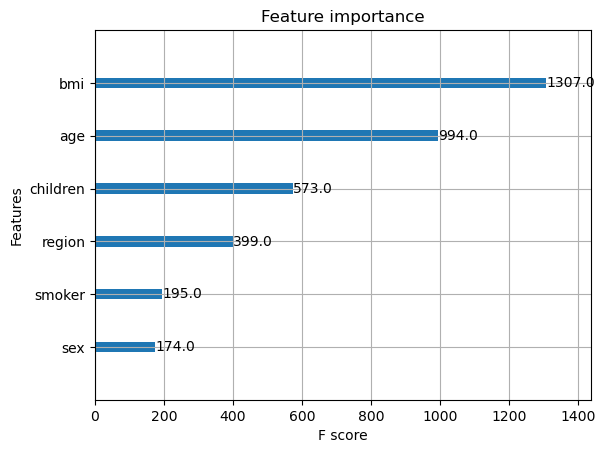

In [46]:
x = df.drop('charges in INR', axis=1)
y = df['charges in INR']


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42) 
xg = XGBRegressor()
xg.fit(x_train,y_train)
xgboost.plot_importance(xg)


# Applying Clustering to see Accuracy Improvement

In [47]:
x = df.drop('charges in INR',axis=1)

In [48]:
labels = KMeans(n_clusters=2,random_state=42).fit_predict(x)

<Axes: xlabel='age', ylabel='charges in INR'>

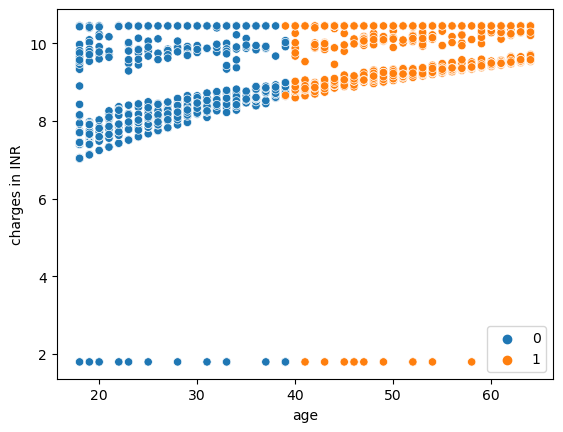

In [49]:
sns.scatterplot(x=x['age'],y = df['charges in INR'],hue=labels)

In [50]:
# age with below 40 and above 40 

<Axes: xlabel='bmi', ylabel='charges in INR'>

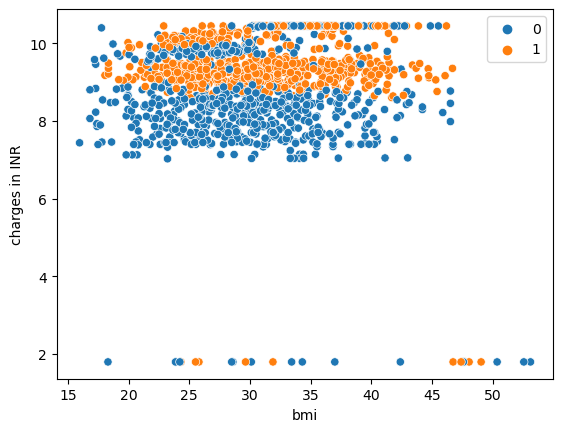

In [51]:
sns.scatterplot(x=x['bmi'],y = df['charges in INR'],hue=labels)

<Axes: xlabel='children', ylabel='charges in INR'>

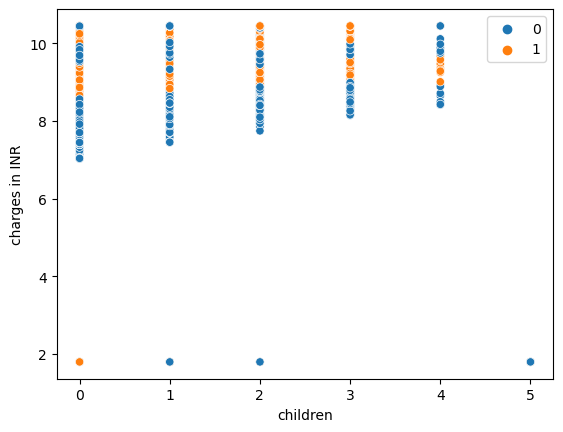

In [52]:
sns.scatterplot(x=x['children'],y = df['charges in INR'],hue=labels)

<Axes: xlabel='region', ylabel='charges in INR'>

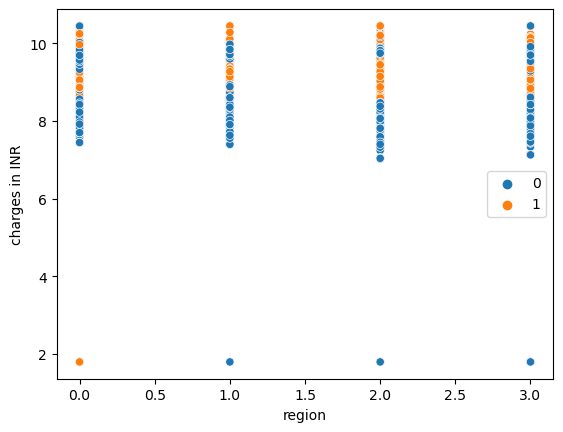

In [53]:
sns.scatterplot(x=x['region'],y = df['charges in INR'],hue=labels)

In [54]:
labels = pd.DataFrame(data = labels,columns=['lables'])

In [55]:
df = df.join(labels,how='left')

In [56]:
df.head()

,children,smoker,region,age,sex,bmi,charges in INR,lables
0,0,0,3,23,1,34.4,7.510892,0
1,1,0,3,19,1,24.6,7.516562,0
2,0,0,3,56,1,40.3,9.268929,1
3,1,0,3,30,0,32.4,8.331041,0
4,5,0,3,19,0,28.6,1.791759,0


In [57]:
k_fold_cross_validation_tuned(df)

,model_name,score_mean,score_std
3,Random_Forest,0.843813,0.061437
9,Gradient_Boosting,0.843183,0.094910
6,Adaboost,0.764990,0.140200
5,XG_Boost,0.757792,0.091021
4,Decision_tree,0.747939,0.117229
2,Ridge,-0.070436,0.894251
0,Linear_Regression,-0.073794,0.903919
7,KNn,-1.906376,6.140315
8,SVR,-2.039238,6.487060
1,Lasso,-2.070857,6.461625


In [58]:
def generate_learning_curve(model_name,model_estimator,df,target='charges in INR'):
    x = df.drop(target,axis=1)
    y = df[['charges in INR']]
    train_size,train_score,test_score = learning_curve(estimator=model_estimator,X=x,y=y,cv=10)
    train_score_mean = np.mean(train_score,axis=1)
    test_score_mean = np.mean(test_score,axis=1)
    plt.plot(train_size,train_score_mean,color='blue')
    plt.plot(train_size,test_score_mean,color='green')
    plt.xlabel('Samples')
    plt.ylabel('Scores')
    plt.title(f'Learning curve for {model_name}')
    plt.legend(['Training Score','Testing Score'])

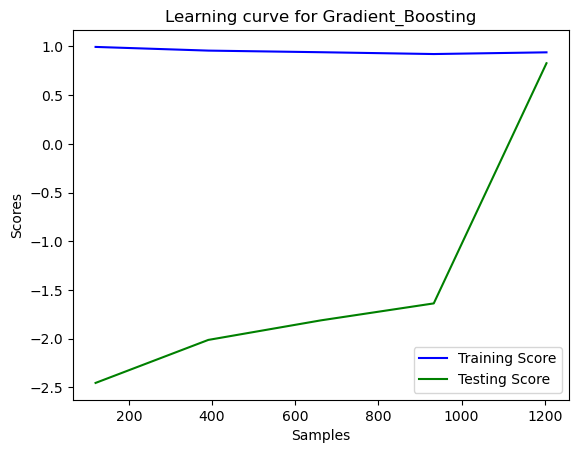

In [59]:
generate_learning_curve('Gradient_Boosting',GradientBoostingRegressor(),df)

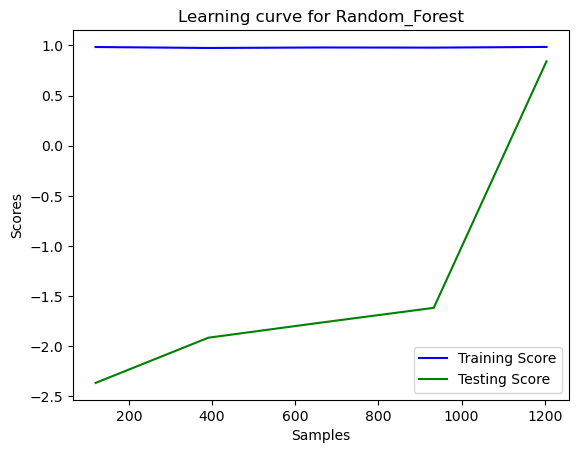

In [60]:
generate_learning_curve('Random_Forest',RandomForestRegressor(),df)

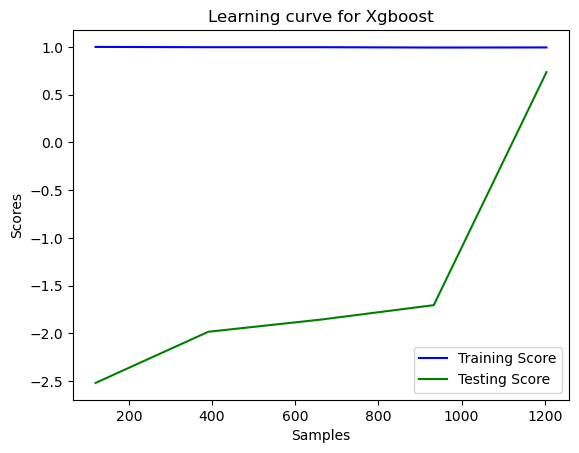

In [61]:
generate_learning_curve('Xgboost',XGBRegressor(),df)